In [1]:
import sys
sys.path.append("../../")

from didgelab.calc.geo import Geo, geotools
from didgelab.evo.nuevolution import Genome, LossFunction, Nuevolution, GeoGenomeA, GeoGenome
from didgelab.util.didge_visualizer import vis_didge
from didgelab.calc.sim.sim import compute_impedance_iteratively, get_notes, compute_impedance, create_segments, get_log_simulation_frequencies, quick_analysis
from didgelab.calc.conv import note_to_freq, freq_to_note_and_cent, note_name

import numpy as np

[(0.0, 32.0),
 (67.41263579255168, 32.0),
 (157.8956269987137, 32.0),
 (341.34147641770926, 49.78859611946028),
 (609.624324591171, 57.65964254975373),
 (668.570122324945, 60.504217989148856),
 (817.5048296147951, 45.07529098001645),
 (848.5513257714363, 45.055521627579836),
 (890.0760437004723, 46.951970574844054),
 (995.7266489760208, 57.878740072527194),
 (1097.5336017494515, 83.76498073389023)]

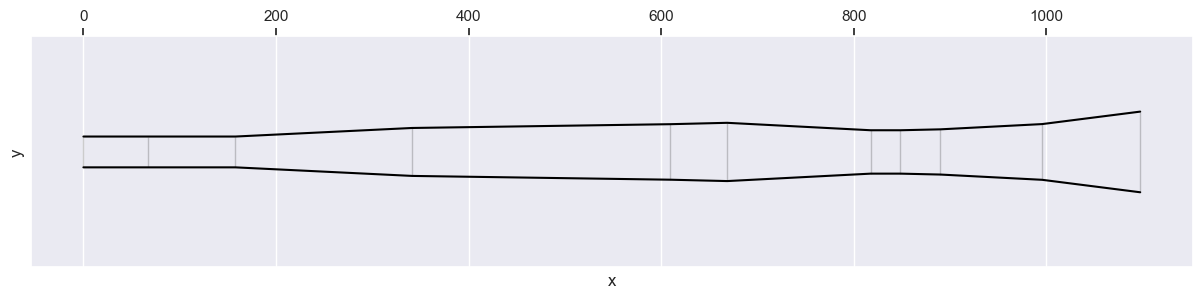

In [25]:
class GeoGenomeB (GeoGenome):

    def build(n_segments):
        return GeoGenomeB(n_genes=(n_segments*2)+2)

    def genome2geo(self) -> Geo:
        d0 = 32

        x = [0]
        y = [d0]
        min_l = 1000
        max_l = 2000

        min_b = 32
        max_b = 100

        d_factor = 75
        min_d = 25

        length = self.genome[0] * (max_l-min_l) + min_l 
        bell_size = self.genome[1] * (max_b-min_b) + min_b

        _x = self.genome[np.arange(2, len(self.genome), 2)]
        _y = self.genome[np.arange(3, len(self.genome), 2)]

        x = [0]
        y = [0]
        
        factor = 0.5
        for segx, segy in zip(_x,_y):
            x.append(x[-1] + segx)
            _y = y[-1] + factor*segy - factor * 0.5
            if _y < 0:
                _y = 0
            y.append(_y)

        x = np.array(x)
        y = np.array(y)
        x /= x[-1]
        y /= y.sum()
        y /= y[-1]
        x *= length
        y = np.array(y) * (bell_size-d0) + d0
        
        geo = list(zip(x,y))
        return Geo(geo)

np.random.seed(19)
x=GeoGenomeB.build(10)

geo = x.genome2geo()
vis_didge(geo)
geo.geo



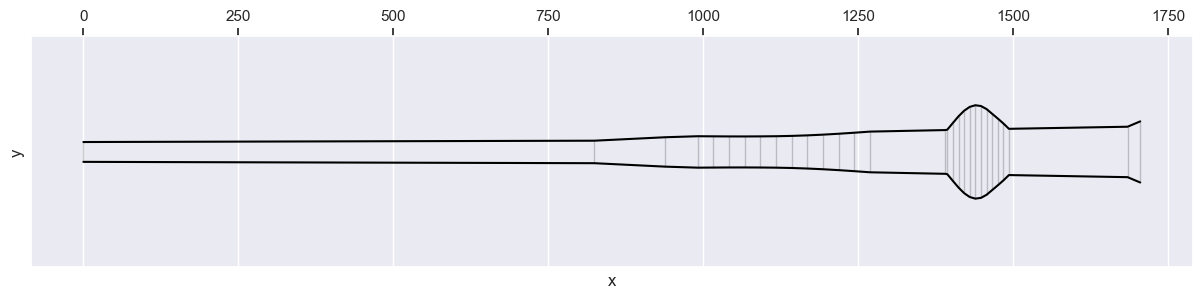

In [2]:
import math

class MbeyaGemome(GeoGenome):

    def add_param(self, name, minval, maxval):
        self.named_params[name] = {
            "index": len(self.named_params),
            "min": minval,
            "max": maxval
        }

    def get_value(self, name):
        p = self.named_params[name]
        v = self.genome[p["index"]]
        v = v*(p["max"]-p["min"]) + p["min"]
        return v

    def __init__(self, n_bubbles=1, add_bubble_prob=0.7):

        self.named_params = {}

        self.d1=32
        self.add_bubble_prob=add_bubble_prob
        self.n_bubbles=n_bubbles

        # straight part
        self.add_param("l_gerade", 500, 1500)
        self.add_param("d_gerade", 0.9, 1.2)

        # opening part
        self.add_param("n_opening_segments", 0, 8)
        self.add_param("opening_factor_x", -2, 2)
        self.add_param("opening_factor_y", -2, 2)
        self.add_param("opening_length", 700, 1000)

        # bell
        self.add_param("d_pre_bell", 40, 50)
        self.add_param("l_bell", 20, 50)
        self.add_param("bellsize", 5, 30)

        # bubble
        for i in range(self.n_bubbles):
            self.add_param(f"add_bubble_{i}", 0, 1)
            self.add_param(f"bubble_height_{i}", -0.5, 1)
            self.add_param(f"bubble_pos_{i}", 0, 1)
            self.add_param(f"bubble_width_{i}", 0, 300)

        GeoGenome.__init__(self, n_genes = len(self.named_params))

    def make_bubble(self, shape, pos, width, height):

        n_segments=11

        i=self.get_index(shape, pos-0.5*width)

        bubbleshape=shape[0:i]

        x=pos-0.5*width
        y=Geo(geo=shape).diameter_at_x(x)

        if shape[i-1][0]<x:
            bubbleshape.append([x,y])

        for j in range(1, n_segments):
            x=pos-0.5*width + j*width/n_segments

            # get diameter at x
            y=Geo(geo=shape).diameter_at_x(x)
            factor=1+math.sin(j*math.pi/(n_segments))*height
            y*=factor

            bubbleshape.append([x,y])

        x=pos+0.5*width
        y=Geo(geo=shape).diameter_at_x(x)
        bubbleshape.append([x,y])

        while shape[i][0]<=bubbleshape[-1][0]+1:
            i+=1
        
        bubbleshape.extend(shape[i:])

        return bubbleshape

    # return last index that is smaller than x
    def get_index(self, shape, x):
        for i in range(len(shape)):
            if shape[i][0]>x:
                return i
        return len(shape)-1

    def genome2geo(self):
        shape=[[0, self.d1]]

        # straight part
        p=[self.get_value("l_gerade"), shape[-1][1]*self.get_value("d_gerade")]
        shape.append(p)

        # opening part
        n_seg=self.get_value("n_opening_segments")
        seg_x=[]
        seg_y=[]
        for i in range(int(n_seg)):
            x=pow(i+1, self.get_value("opening_factor_x"))
            y=pow(i+1, self.get_value("opening_factor_y"))
            seg_x.append(x)
            seg_y.append(y)

        def normalize(arr):
            m=sum(arr)
            return [x/m for x in arr]

        seg_x=normalize(seg_x)
        seg_y=normalize(seg_y)
        seg_x=[x*self.get_value("opening_length") for x in seg_x]
        seg_y=[y*self.get_value("d_pre_bell") for y in seg_y]

        start_x=shape[-1][0]
        start_y=shape[-1][1]
        for i in range(int(n_seg)):
            x=sum(seg_x[0:i+1]) + start_x
            y=sum(seg_y[0:i+1]) + start_y
            shape.append([x,y])

        p=[shape[-1][0] + self.get_value("l_bell"), shape[-1][1]+self.get_value("bellsize")]
        shape.append(p)

        # add bubble
        for i in range(self.n_bubbles):
            if self.get_value(f"add_bubble_{i}")<self.add_bubble_prob:
                pos=shape[-1][0]*self.get_value(f"bubble_pos_{i}")
                width=self.get_value(f"bubble_width_{i}")
                height=self.get_value(f"bubble_height_{i}")
                if pos-width/2<-10:
                    pos=width/2 + 10
                if pos+width/2+10>shape[-1][0]:
                    pos=shape[-1][0]-width/2 - 10
                shape=self.make_bubble(shape, pos, width, height)

        geo=Geo(shape)
        geo=geotools.fix_zero_length_segments(geo)
        return geo

x = MbeyaGemome(n_bubbles=3, add_bubble_prob=0.7)
x.genome = np.array([
            0.32423323736178566,
            0.7803777951857941,
            0.6288938960542444,
            0.6003125043355609,
            0.4429223276463603,
            0.53429073972848,
            0.5079640799066548,
            0.012966388208378032,
            0.4876606631829039,
            0.29494212042362766,
            0.42571055904035005,
            0.8387794709879011,
            0.2628657735146749,
            0.4774932280301668,
            0.24598066300677274,
            0.6627717667491584,
            0.9276404060363084,
            0.6468919622988213,
            0.8988404615896214,
            0.8466372766345527,
            0.3312124097687333
        ])

geo = x.genome2geo()
vis_didge(geo)

In [9]:
from typing import DefaultDict
import pandas as pd

freqs = get_log_simulation_frequencies(1, 1000, 1)
segments = create_segments(geo)
impedance = compute_impedance(segments, freqs)
notes = get_notes(freqs, impedance)

target_f = np.arange(1,15) * note_to_freq(-31)
log_target_freq = np.log2(target_f) 
logfreq = np.log2(notes.freq)
deltas = DefaultDict(list)
for i in range(len(logfreq)):
    closest_target_i = np.argmin(np.abs(target_f - notes.freq.iloc[i]))

    if i == 5:
        print(notes.freq.iloc[i])
        print(target_f)
        print(notes.freq[i], target_f[i])
    # closest_target_i = np.argmin(np.abs(log_target_freq - logfreq[i]))
    # print(closest_target_i)
    # print(notes.freq[i], target_f[i])
    # print(np.argmin(np.abs(log_target_freq - logfreq[i])))

    deltas["mult"].append(closest_target_i)
    deltas["freq"].append(notes.freq[i])
    deltas["target"].append(target_f[i])
    
deltas = pd.DataFrame(deltas)
deltas.target = deltas.target.round(2)
deltas["diff"] = np.abs(deltas.target - deltas.freq)
print(deltas)


546.8494889205002 440.4971518761113
   mult        freq  target        diff
0     0   73.220041   73.42    0.199959
1     1  144.674482  146.83    2.155518
2     2  229.523808  220.25    9.273808
3     3  323.285876  293.66   29.625876
4     5  450.900927  367.08   83.820927
5     6  546.849489  440.50  106.349489
6     8  671.309074  513.91  157.399074
7    10  796.483133  587.33  209.153133
8    11  910.700795  660.75  249.950795


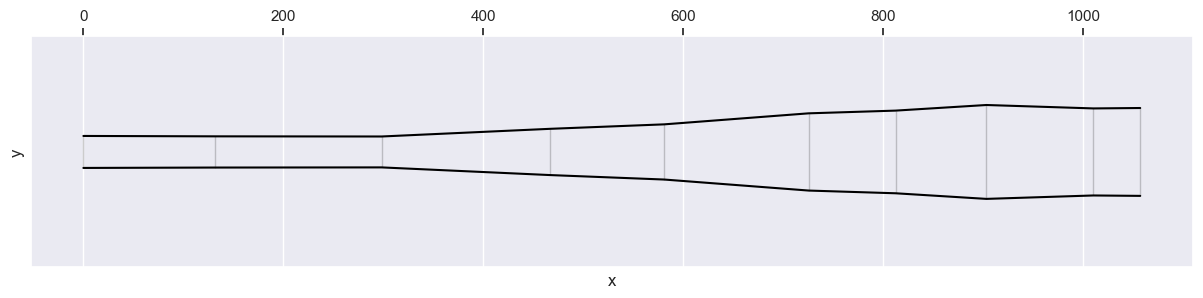

In [28]:
geo = [
                [
                    0.0,
                    32.0
                ],
                [
                    131.253010313747,
                    31.229914044848854
                ],
                [
                    298.39804588607586,
                    30.923463657900975
                ],
                [
                    466.85040324310313,
                    46.26572467804467
                ],
                [
                    581.171128431663,
                    55.21624209741306
                ],
                [
                    725.7140762974715,
                    77.27348395642383
                ],
                [
                    812.6428600671899,
                    82.71112088298347
                ],
                [
                    903.5062199428942,
                    93.93579994990073
                ],
                [
                    1010.6048294055103,
                    87.09408826315999
                ],
                [
                    1057.4332452124145,
                    87.9165776836469
                ]
            ]
geo = Geo(geo)
vis_didge(geo)


In [55]:
def get_fundamental_freq(geo):
    segments = create_segments(geo)
    freqs = get_log_simulation_frequencies(50, 120, 2)
    impedance = compute_impedance(segments, freqs)
    fundamental = np.argmax(impedance)
    return freqs[fundamental]

get_fundamental_freq(geo)

73.54334320929749

In [22]:

class MultiplierLoss(LossFunction):
    
    def __init__(self):
        self.target_f = np.arange(1,15) * note_to_freq(-31)
        self.target_f = np.log2(self.target_f)

    def loss(self, genome : GeoGenome):
        geo = genome.genome2geo()
        freqs = get_log_simulation_frequencies(1, 1000, 10)
        segments = create_segments(geo)
        impedance = compute_impedance(segments, freqs)
        notes = get_notes(freqs, impedance)

        notes = notes[notes.impedance>3]

        logfreq = np.log2(notes.freq)
        deltas = []

        targets = []
        for freq in logfreq:

            closest_target_i = np.argmin(np.abs(self.target_f - freq))
            deltas.append(np.abs(self.target_f[closest_target_i]-freq))
            targets.append(np.exp2(self.target_f[closest_target_i]))

        notes["targets"] = targets
        notes["deltas"] = deltas
        print(notes[["freq", "targets", "deltas"]])
        fundamental_loss = 5*deltas[0]
        harmonic_loss = np.mean(deltas[1:])
        n_notes_loss = (10-len(notes))/10

        return {
            "total": fundamental_loss + harmonic_loss + n_notes_loss,
            "fundamental_loss": fundamental_loss,
            "harmonic_loss": harmonic_loss,
            "n_notes_loss": n_notes_loss
        }

MultiplierLoss().loss(x)


         freq     targets    deltas
0   73.516695   73.416192  0.001974
1  125.801037  146.832384  0.223026
2  245.855474  220.248576  0.158678
3  307.974409  293.664768  0.068640


{'total': 0.7599829165169882,
 'fundamental_loss': 0.009868099043370826,
 'harmonic_loss': 0.1501148174736174,
 'n_notes_loss': 0.6}

In [9]:
x = 440
y = np.log2(x)
z = np.exp2(y)
print(x)
print(y)
print(z)


440
8.78135971352466
440.0000000000001


,note_name,cent_diff,note_nr,freq,impedance,rel_imp
0,D1,-2.368344,-31,73.516695,19.199941,1.000000
1,B2,-32.368344,-22,125.801037,8.078651,0.420764
2,B3,7.631656,-10,245.855474,3.099962,0.161457
3,D#3,17.631656,-6,307.974409,3.181799,0.165719
4,A4,37.631656,0,430.538965,1.866846,0.097232
5,C4,47.631656,3,509.051097,1.471886,0.076661
6,E4,47.631656,7,641.364193,1.482830,0.077231
7,F#4,-2.368344,9,741.001850,0.854101,0.044485
8,G#4,-32.368344,11,846.285126,1.303750,0.067904
9,A#5,-2.368344,13,933.603828,0.473861,0.024680


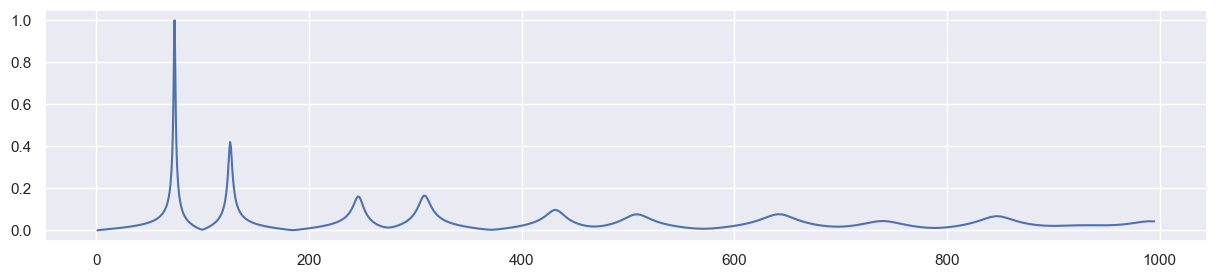

In [36]:
geo = x.genome2geo()
freqs = get_log_simulation_frequencies(1, 1000, 10)
segments = create_segments(geo)
impedance = compute_impedance(segments, freqs)
notes = get_notes(freqs, impedance)

import matplotlib.pyplot as plt
plt.plot(freqs, impedance/impedance.max())
notes

<AxesSubplot: xlabel='generation', ylabel='loss'>

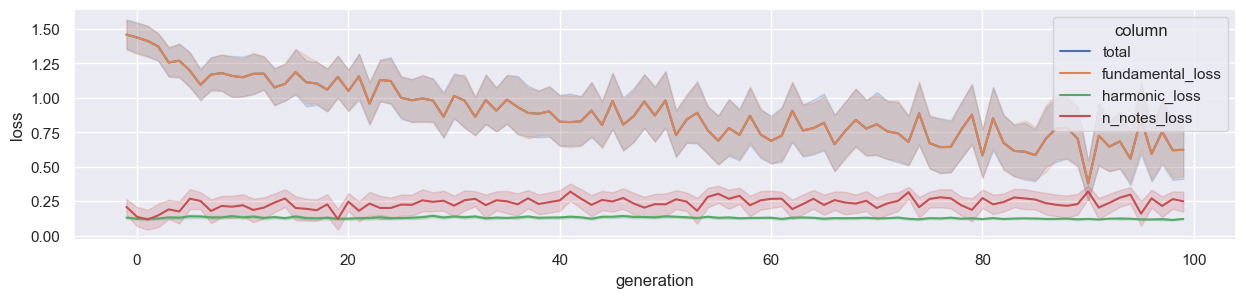

In [33]:
import pandas as pd
import seaborn as sns
infile = "/tmp/evolution_operations.csv"
df = pd.read_csv(infile)

dfs = []
for c in df.columns:
    if c[0:5] == "loss_":
        df2 = df[["generation"]].copy()
        df2["column"] = c[5:]
        df2["loss"] = df[c]
        dfs.append(df2)

dfs = pd.concat(dfs)
sns.lineplot(data=dfs, x="generation", y="loss", hue="column")

<AxesSubplot: xlabel='generation', ylabel='loss'>

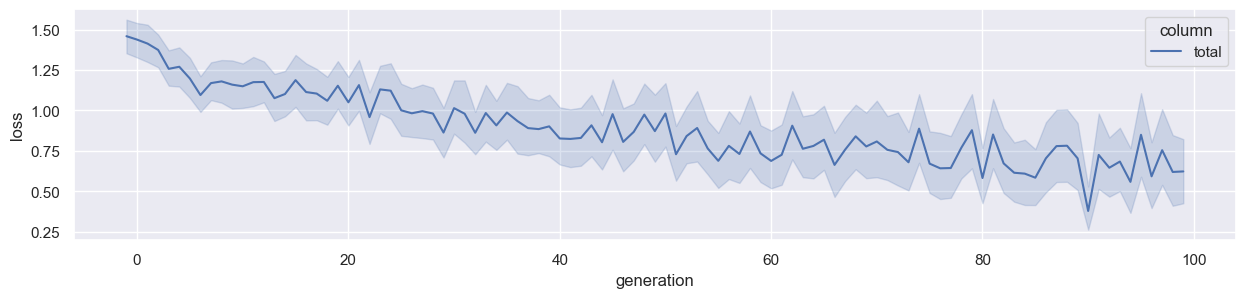

In [34]:
sns.lineplot(data=dfs.query("column == 'total'"), x="generation", y="loss", hue="column")

In [45]:
n_steps = 4
1-(np.arange(n_steps)/n_steps)
np.arange(1,n_steps+1) / n_steps

rates = 0.5-(np.arange(n_steps)/n_steps)
rates[rates<0] = 0
rates

array([0.5 , 0.25, 0.  , 0.  ])

In [53]:
class Test:

    def p(self):
        n_steps = 4
        self.rates = 0.5-(np.arange(n_steps)/n_steps)
        print(self.rates)
        self.rates = self.rates[self.rates<0] = 0

Test().p()

[ 0.5   0.25  0.   -0.25]


TypeError: 'int' object does not support item assignment

In [4]:
geo = [
                [
                    0,
                    32
                ],
                [
                    824.2332373617857,
                    36.291626833783624
                ],
                [
                    938.5383101258299,
                    47.41421865749545
                ],
                [
                    990.8197880325014,
                    50.702520640391576
                ],
                [
                    1016.1190718334916,
                    50.36331653497788
                ],
                [
                    1041.418355634482,
                    50.06778254449459
                ],
                [
                    1066.7176394354722,
                    49.98266365426681
                ],
                [
                    1092.0169232364624,
                    50.23419526961311
                ],
                [
                    1117.3162070374526,
                    50.70781550151675
                ],
                [
                    1142.6154908384428,
                    51.780675979964954
                ],
                [
                    1167.914774639433,
                    53.49163447226997
                ],
                [
                    1193.2140584404233,
                    55.82680449783917
                ],
                [
                    1218.5133422414135,
                    58.71866665619904
                ],
                [
                    1243.8126260424037,
                    62.049773122381154
                ],
                [
                    1269.111909843394,
                    65.64483449749272
                ],
                [
                    1390.6131813032691,
                    70.58439153193886
                ],
                [
                    1393.758032975681,
                    71.92599285038644
                ],
                [
                    1402.7910986966465,
                    93.71437144023743
                ],
                [
                    1411.8241644176119,
                    114.99788266490128
                ],
                [
                    1420.8572301385775,
                    132.99369744355093
                ],
                [
                    1429.890295859543,
                    145.41550294345288
                ],
                [
                    1438.9233615805083,
                    150.67041153629205
                ],
                [
                    1447.956427301474,
                    148.1882808369389
                ],
                [
                    1456.9894930224393,
                    138.34577394936827
                ],
                [
                    1466.0225587434047,
                    123.11785817049423
                ],
                [
                    1475.05562446437,
                    107.89541326064044
                ],
                [
                    1484.0886901853355,
                    92.04499105273281
                ],
                [
                    1493.1217559063011,
                    74.60988619888258
                ],
                [
                    1684.5204592803298,
                    81.37126763285018
                ],
                [
                    1704.909450926581,
                    98.56278421242277
                ]
            ]

geo = Geo(geo)
geo

In [33]:
genome = [
            0.32423323736178566,
            0.7803777951857941,
            0.6288938960542444,
            0.6003125043355609,
            0.4429223276463603,
            0.53429073972848,
            0.5079640799066548,
            0.012966388208378032,
            0.4876606631829039,
            0.29494212042362766,
            0.42571055904035005,
            0.8387794709879011,
            0.2628657735146749,
            0.4774932280301668,
            0.24598066300677274,
            0.6627717667491584,
            0.9276404060363084,
            0.6468919622988213,
            0.8988404615896214,
            0.8466372766345527,
            0.3312124097687333
        ]

class MultiplierLoss(LossFunction):
    
    def __init__(self):
        self.target_f = np.arange(1,15) * note_to_freq(-31)
        self.log_target_f = np.log2(self.target_f)

    def loss(self, genome : GeoGenome):
        geo = genome.genome2geo()
        freqs = get_log_simulation_frequencies(1, 1000, 10)
        segments = create_segments(geo)
        impedance = compute_impedance(segments, freqs)
        notes = get_notes(freqs, impedance)
        # notes = notes[notes.impedance>3]

        logfreq = np.log2(notes.freq)
        deltas = []
        for i in range(len(logfreq)):
            freq = logfreq[i]
            closest_target_i = np.argmin(np.abs(self.log_target_f - freq))
            deltas.append(np.abs(self.target_f[closest_target_i]-freq))

        fundamental_loss = 5*np.log2(deltas[0])
        if len(deltas) == 1:
            harmonic_loss = 10
        else:
            harmonic_loss = np.mean(np.log2(deltas[1:]))
        n_notes_loss = (10-len(notes))/10

        return {
            "total": fundamental_loss + harmonic_loss + n_notes_loss,
            "fundamental_loss": fundamental_loss,
            "harmonic_loss": harmonic_loss,
            "n_notes_loss": n_notes_loss
        }

g = MbeyaGemome()
g.genome = genome

loss = MultiplierLoss()
loss.loss(g)

{'total': 39.259408272160876,
 'fundamental_loss': 30.3527901637692,
 'harmonic_loss': 8.806618108391671,
 'n_notes_loss': 0.1}

In [23]:
target_freq = np.arange(1,20) * note_to_freq(-31)
target_freq = target_freq[target_freq<1000]
freq = 770

mini = np.argmin(np.abs(target_freq - freq))
target_freq[mini]
target_freq[mini]


734.1619197935188

In [5]:
target_f = np.arange(1,15) * note_to_freq(-31)
print(target_f)
log_target_freq = np.log2(target_f) 
logfreq = np.log2(notes.freq)
deltas = DefaultDict(list)
for i in range(len(logfreq)):
    closest_target_i = np.argmin(np.abs(log_target_freq - logfreq[i]))
    print(closest_target_i)
    print(notes.freq[i], target_f[i])
    print(np.argmin(np.abs(log_target_freq - logfreq[i])))

    deltas["mult"].append(closest_target_i)
    deltas["freq"].append(notes.freq[i])
    deltas["target"].append(target_f[i])
    
deltas = pd.DataFrame(deltas)
deltas.target = deltas.target.round(2)
deltas["diff"] = np.abs(deltas.target - deltas.freq)
print(deltas)



[  73.41619198  146.83238396  220.24857594  293.66476792  367.0809599
  440.49715188  513.91334386  587.32953583  660.74572781  734.16191979
  807.57811177  880.99430375  954.41049573 1027.82668771]


NameError: name 'notes' is not defined